In [354]:
#Testing
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
import ruptures as rpt
import warnings
import holidays
from hijri_converter import convert
from datetime import date,datetime, timedelta
from prophet.diagnostics import performance_metrics, cross_validation

warnings.filterwarnings("ignore")

## Parameters

In [355]:
growth='linear'
mcmc_samples=10 #300

holidays_prior_scale=0.25
changepoint_prior_scale=0.10
seasonality_mode='additive'
yearly_seasonality=10
weekly_seasonality=True
daily_seasonality=False   
country_name='SA'
interval_width=0.95
#create an empty dataframe with ds an y column
customholidays_df = pd.DataFrame({'ds': [], 'holiday': []})

seasonality_mode=seasonality_mode
yearly_seasonality=6

monthly_season='monthly'
monthly_season_period=30.5
monthly_season_fourier_order=10


ramadan_season='Monthly_Ramadan_season'
ramadan_period = 29.53
ramadan_fourier_order=10

#Weekend
start_date ='01-01-2018'
end_date = '01-01-2024'
weekend_days = [4]  #4 is Friday:  0-6:Mon-Sun

In [356]:
# Load and prepare the data for Prophet
df = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')
data = df.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'y'})
data = data[['ds', 'y']]
data['ds']=pd.to_datetime(data['ds'])
#data.head(2)

### Parameter  Growth  

In [357]:
# Function to decide whether data['y'] is logistic or linear

def detect_growth_pattern(data, curvature_threshold=0.1):
    # Calculate second derivative (curvature)
    curvature = np.gradient(np.gradient(data))
    # Check if the curvature is close to zero
    if np.abs(np.mean(curvature)) <= curvature_threshold:
        return 'linear'
    else:
        return 'logistic'
    
# Detect growth pattern
growth = detect_growth_pattern(data['y'])

# Define a percentile value (e.g., 99th percentile)
percentile_value = 99

# Calculate the specified percentile for the cap
cap = (np.percentile(data['y'], percentile_value)) * 1.5

# Define a lower percentile value (e.g., 5th percentile) for the floor
percentile_floor = 5

# Calculate the specified percentile for the floor
floor = np.percentile(data['y'], percentile_floor)
#floor and cap can be used while predicting we need to add them in future_dataframe'
#print('Parameter : growth=' +growth)

### Parameter 2: Change points PELT Algo

In [358]:
def calculate_penalty(data, sensitivity, cal=[6, 3, 1.5]):
    if sensitivity == "Low":
        return cal[0] * math.log(len(data))
    elif sensitivity == "Medium":
        return cal[1] * math.log(len(data))
    elif sensitivity == "High":
        return cal[2] * math.log(len(data))

In [359]:
peltdata = data['y'].values
# You can choose between "l1" and "l2" cost functions
model = "l1"  

algo = rpt.Pelt(model=model, min_size=1, jump=1).fit(peltdata) 
penalty= calculate_penalty(peltdata, "Medium") 
result = algo.predict(pen=3) 

changepointDates=[]
for index in result:
    a=data.iloc[index-1]['ds']
    changepointDates.append(a)

changepointDates=pd.DataFrame(changepointDates, columns=['ds'])
changepointDates['ds'] = pd.to_datetime(changepointDates['ds'])

changepoints=changepointDates['ds']     
#holidays=holidays
#changepointDates.head(2)

# Outlier

In [360]:
# Assuming you have calculated Q1, Q3, IQR, lower_bound, and upper_bound
# as per the previous snippet
Q1 = data['y'].quantile(0.25)
Q3 = data['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

soutliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

# Identifying outliers
outliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

# Replace outlier values with the mean
data.loc[outliers.index, 'y'] = data['y'].mean()

# Optional: Print the updated DataFrame
#data.head(2)

## Ramadan Holidays

In [361]:
def generate_ramadan_dates_df(start_year, end_year):
    ramadan_dates = []

    for year in range(start_year, end_year + 1):
        # The Umm al-Qura calendar uses Hijri dates for Islamic months
        hijri_year_start = convert.Gregorian(year, 1, 1).to_hijri()
        hijri_year_end = convert.Gregorian(year, 12, 30).to_hijri()

        for day in range(1, 30):  # Assuming Ramadan lasts for 29 or 30 days
            # Find the date of Ramadan in the Hijri calendar
            ramadan_date = convert.Hijri(hijri_year_start.year, 9, day).to_gregorian()

            # Append the date to the list
            ramadan_dates.append(ramadan_date)

    # Create a DataFrame with a column named 'ramadan_dates'
    ramadan_df = pd.DataFrame({'ds': ramadan_dates})
    return ramadan_df

In [362]:
start_year = datetime.strptime(start_date, '%d-%m-%Y').year
end_year = datetime.strptime(end_date, '%d-%m-%Y').year
ramadan_df = generate_ramadan_dates_df(start_year, end_year)

## Weekend

In [363]:
def generate_weekends(start_date, end_date, weekend_days):
    start_date = datetime.strptime(start_date, '%d-%m-%Y')
    end_date = datetime.strptime(end_date, '%d-%m-%Y')
    
    weekends = []
    current_date = start_date

    while current_date <= end_date:
        # Check if the current date is a weekend
        if current_date.weekday() in weekend_days:
            weekends.append(current_date)
        current_date += timedelta(days=1)

    # Create a DataFrame with day names and dates
    weekend_df = {'ds': weekends,
                  'holiday': [day.strftime('%A') for day in weekends]}

    df_weekends = pd.DataFrame(weekend_df)
    return df_weekends

In [364]:
df_weekends = generate_weekends(start_date, end_date, weekend_days)
data['is_weekend'] = data['ds'].isin(df_weekends['ds']).astype(int)
data['is_weekday'] = (data['is_weekend'] == 0).astype(int)
#df_weekends 

## Adding Extra Columns To dataframe

In [365]:
# Create a binary indicator for Ramadan
data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)
prophet_data= data
prophet_data['cap']=cap
prophet_data['floor']=floor

# Training

### Fitting the Model

In [366]:
model = Prophet( growth=growth  
                ,mcmc_samples=mcmc_samples
               ,holidays= customholidays_df #if customholidays_df.empty else None
                ,changepoints=changepoints   
                ,holidays_prior_scale=holidays_prior_scale
                ,changepoint_prior_scale=changepoint_prior_scale
                ,seasonality_mode=seasonality_mode
                ,yearly_seasonality=yearly_seasonality
                ,weekly_seasonality=weekly_seasonality
                ,daily_seasonality=daily_seasonality
                ,interval_width=interval_width
                )
model.add_country_holidays(country_name=country_name)

model.add_seasonality(
                 name='weekend'
                ,period=1  
                ,fourier_order=6      
                ,condition_name='is_weekend')

model.add_seasonality(
                 name='weekday'
                ,period=1  
                ,fourier_order=6      
                ,condition_name='is_weekday')

model.add_seasonality(
                 name=ramadan_season
                ,period=ramadan_period  
                ,fourier_order=ramadan_fourier_order      
                ,condition_name='is_ramadan'
                )
metric=model.fit(prophet_data)
metric

16:13:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:29 - cmdstanpy - INFO - CmdStan done processing.
16:13:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpd

# Generate future dates

In [367]:
### Generate future dates




future_df = model.make_future_dataframe(periods=30)
firstdate=future_df['ds'].iloc[0].strftime('%d-%m-%Y')
lastdate=future_df['ds'].iloc[-1].strftime('%d-%m-%Y')
future_weekends = generate_weekends(firstdate, lastdate, weekend_days)

future_df['is_ramadan'] = future_df['ds'].isin(ramadan_df['ds']).astype(int)
future_df['cap'] = cap
future_df['floor'] = floor

# Add the 'holidays' column to the future DataFrame
#future_df['holidays'] = 0
#future_df.loc[future_df['ds'].isin(df_weekends['ds']), 'holidays'] = 1



future_df['is_weekend'] = future_df['ds'].isin(future_weekends['ds']).astype(int)
future_df['is_weekday'] = (future_df['is_weekend'] == 0).astype(int)


### Generate predictions
forecast = model.predict(future_df)

### Analyze and visualize results
forecast=forecast[['ds', 'yhat']].tail(30)# View predicted values for the next 30 days
forecast.to_csv('/home/ajaz/DemandForecasting/Data/Output/forecast.csv')
 
#print('Sucessfully Exported')

In [368]:
#future_df

In [369]:
#future_df.head(2)

In [370]:
#fig = model.plot(model.predict(future_df))

## Cross Validation

In [371]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '30 days')
df_p = performance_metrics(df_cv)
#df_p.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

16:13:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:32 - cmdstanpy - INFO - CmdStan done processing.
16:13:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, c

16:13:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:34 - cmdstanpy - INFO - CmdStan done processing.
16:13:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to l

16:13:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:37 - cmdstanpy - INFO - CmdStan done processing.
16:13:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to l

16:13:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:43 - cmdstanpy - INFO - CmdStan done processing.
16:13:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to l

16:13:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:52 - cmdstanpy - INFO - CmdStan done processing.
16:13:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to l

16:13:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:03 - cmdstanpy - INFO - CmdStan done processing.
16:14:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpd

16:14:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:16 - cmdstanpy - INFO - CmdStan done processing.
16:14:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpd

16:14:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:33 - cmdstanpy - INFO - CmdStan done processing.
16:14:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpd

In [372]:
df_p = performance_metrics(df_cv)
#Mean MAPE across all horizons
overall_mape = np.mean(df_p['smape'])
# Median MAPE (more robust to outliers)
overall_mape_median = np.median(df_p['smape'])
MAPEresult = overall_mape_median

# Comparision of ACtual And predicted Data

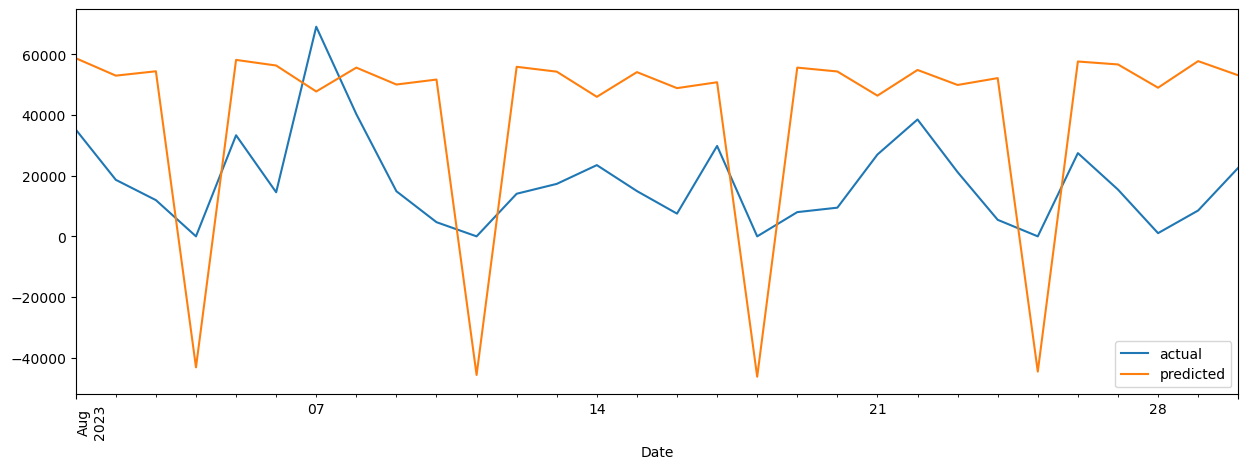

In [373]:
#Create comment for the following code

actualdata = pd.read_csv('/home/ajaz/DemandForecasting/Data/actualdata.csv')
actualdata = actualdata.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'actual'})
actualdata['ds']=pd.to_datetime(actualdata['ds'])

predicteddata =forecast[['ds', 'yhat']].tail(30)
predicteddata = predicteddata.rename(columns={'ds': 'ds', 'yhat': 'predicted'})
predicteddata['ds']=pd.to_datetime(predicteddata['ds'])

finaldata = pd.merge(actualdata,predicteddata,on='ds')
finaldata.plot(x='ds', y=['actual', 'predicted'], kind='line')
#show the day name x axis
plt.xticks(rotation=90)
plt.xlabel('Date')
fig = plt.gcf()
fig.set_size_inches(15, 5)

#finaldata.to_csv('/home/ajaz/DemandForecasting/Data/final.csv')